In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation 
from IPython.display import HTML

IPython literally to just display the animation matplotlib, i dont know how to use this much RIP BOZO.

Typical Mv values:

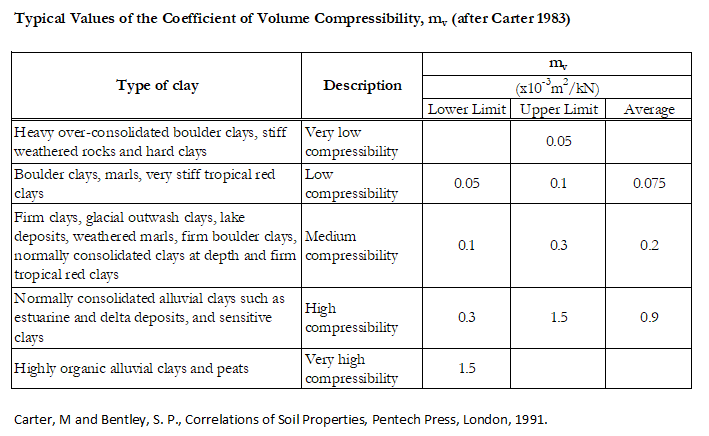

Typical Cv values:

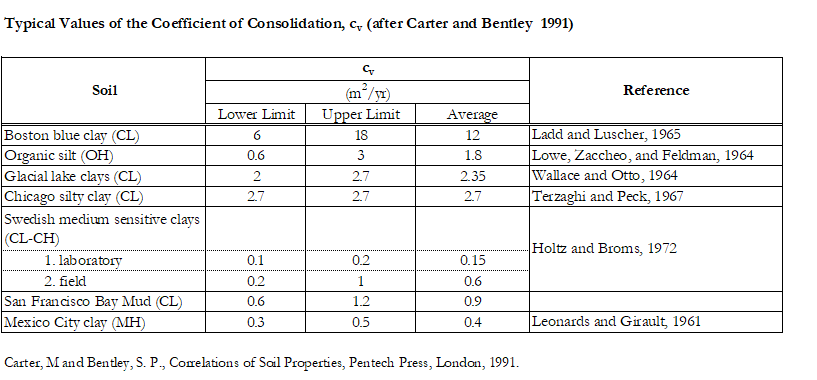



In [2]:
H = 5
num = 100
nodes = num + 1
P = 100 # stress applied 
Tx = 60*60*24*365 # seconds to a year Please keeps this within days 
time_step = 100 
dt = Tx / time_step
Cv = 2e-7 # m^2/s (coefficient of consolidation)
Mv = 5e-4 # 1/kPa  (or m^2/kN)

time_factor = (Cv * dt) / H**2

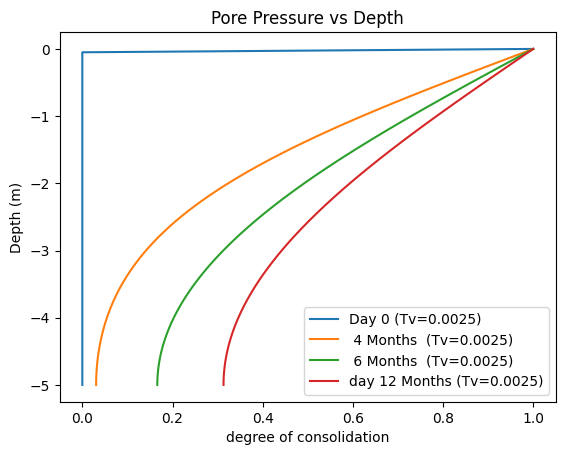

In [3]:

def create_local(Cv, Z):
    he = np.diff(Z)
    if np.round(he[0:1]) == np.round(he[1:2]):
        he = he[0:1]
        me = np.array([[2,1], [1,2]])
        Me = (he / 6) * me
        ke = np.array([[1,-1], [-1,1]])
        Ke = (Cv / he) * ke
        return Me, Ke 
    else:
        print("ERROR - 'he' not uniform")


def create_global(Matrix, num_nodes):
    num_nodes = int(num_nodes)
    Global_M = np.zeros((num_nodes,num_nodes))
    n = np.arange(num_nodes)
    for i in range(np.max(n)):
        i = int(i)
        Global_M[i : (i+2), i : (i+2)] += Matrix
    return Global_M


def boundary_conditions(LF, nodes):
    p = 0
    LF[:,p] = 0
    LF[p,:] = 0
    LF[p,p] = 1
    return LF


def solve_timestep(GMe, B, U0, time_step, nodes):
    p = 0
    GMe[:,p] = 0
    GMe[p,:] = 0
    GMe[p,p] = 1

    U0[p] = 0
    linear_form = GMe @ U0
    loop = np.arange(int(time_step))

    for i in loop:
        if i == 0: 
            pass
        elif i == 1:
            data = U0
            linear_form = GMe @ data
            linear_form[p] = 0
            Un = np.linalg.solve(B, linear_form)
            Un = np.array([Un])
            data = data.reshape(-1, 1).T
            data = np.concatenate((data,Un), axis=0)
        elif i > 1:
            Un = data[(i-1):i,:nodes]
            Un = Un.T
            linear_form = GMe @ Un 
            Un1 = np.linalg.solve(B, linear_form)
            Un1 = Un1.reshape(-1, 1).T
            data = np.concatenate((data,Un1), axis=0)
    return data
        
def interval_plotting():
    fig = plt.figure()
    axis = plt.axes(xlim = (0,4),
        ylim = (-2,2))
    line, = axis.plot([],[], lw = 3)

    fig = plt.figure()
    
    axis = plt.axes(xlim = (0,4),
                ylim = (-2,2))
    line, = axis.plot([],[], lw = 3)

    def init():
        line.set_data([],[])
        return line,

    def animate(i):
        x = np.linspace(0, 4, 1000)
        y = np.sin(2 * np.pi * (x - 0.01 * i))
        line.set_data(x,y)
    return line,


Z = -np.linspace(0, H, num = nodes)
U0 = P*np.ones(Z.shape, dtype=float)

Me, Ke = create_local(Cv = Cv, Z=Z)
GMe, GKe = create_global(Me, nodes), create_global(Ke, nodes)
bilinear_form = (GMe) + (dt * GKe)

B = boundary_conditions(bilinear_form, nodes)
data = solve_timestep(GMe, B, U0, time_step, nodes)

cdata = 1 - (data / P) 



plt.plot(cdata[0, :], Z, label = f"Day 0 (Tv={time_factor:.4f})")
plt.plot(cdata[int(time_step/3), :],Z, label= f" 4 Months  (Tv={time_factor:.4f})")
plt.plot(cdata[int((2*time_step)/3), :],Z, label= f" 6 Months  (Tv={time_factor:.4f})")
plt.plot(cdata[(time_step-1), :],Z, label= f"day 12 Months (Tv={time_factor:.4f})")
plt.legend()
plt.xlabel("degree of consolidation")
plt.ylabel("Depth (m)")
plt.title("Pore Pressure vs Depth")
plt.show()




FEA Version to get local degree of consolidation, for easy (i think i have done this) the intial pore pressure is stated but this is literally just the intial load. Then just used simple np.linspace to make a 1d nodes using numpy. the local degree of consolidation canbe easily calculated via the equation:

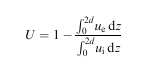

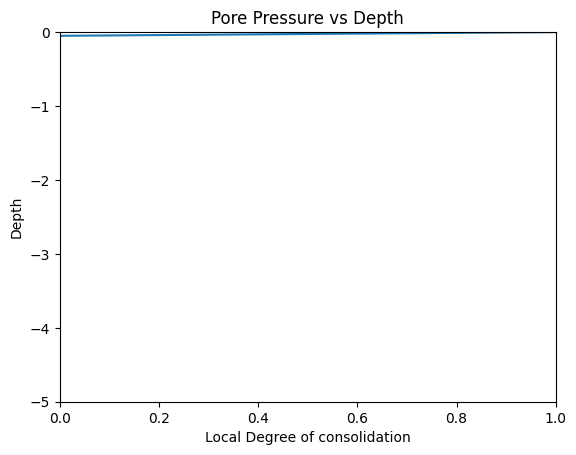

In [ ]:
t = cdata
y = Z

fig, axis = plt.subplots()
axis.set_xlim(0,1)
axis.set_ylim(-5,0)
axis.set_xlabel("Local Degree of consolidation")
axis.set_ylabel("Depth")
plt.title("Local Degree of Consolidation vs Depth throughout time")

animated_plot, = axis.plot([],[])


def update_data(frame):
    animated_plot.set_data(t[frame:frame+1],y)
    return animated_plot, 

animation = FuncAnimation(fig = fig,
                          func =update_data,
                          frames = len(t),
                          interval=25                     
                          )


HTML(animation.to_jshtml())

So total settlement we will use local degree of consolidation, we will make this to average consolidation (or maybe even make it as local settlement then add to get total settlement), and then use the average degree of consolidation to get the total settlement of the soil in a 1D. 

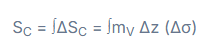


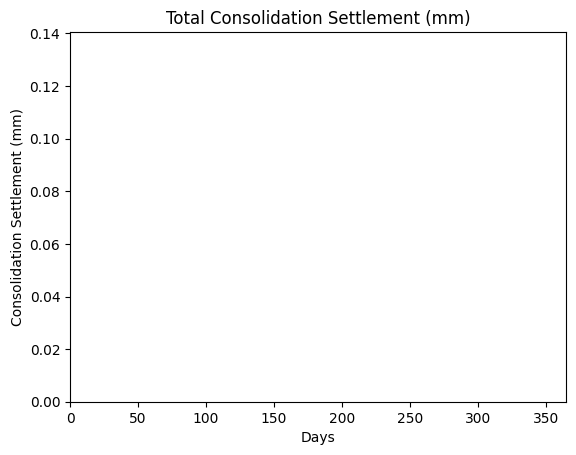

In [ ]:

def average_degree_consolidation():
    ab = np.array([0])
    for row in cdata:
        mean = np.mean(row)
        me = np.array(mean)
        ab = np.vstack((ab, me))
    return np.delete(ab, 0, axis = 0)

def get_settlement(average_consolidation):
    total_settlement = Mv * P * H 
    S_T = total_settlement * average_consolidation
    return S_T


ab = average_degree_consolidation()
settlement_data = get_settlement(ab)
y = settlement_data
x = np.linspace(0,( Tx / (60*60*24)),time_step) # 60*60*24 to turns the axis units into days 

fig, axis = plt.subplots()
axis.set_xlim(0,(Tx / (60*60*24)))
axis.set_ylim(0,np.max(y))
axis.set_xlabel("Days")
axis.set_ylabel("Consolidation Settlement (mm)")
plt.title("Total Consolidation Settlement (mm)")

animated_plot, = axis.plot([],[])

def update_data(frame):
    animated_plot.set_data(x[:frame],y[:frame])
    return animated_plot, 

animation = FuncAnimation(fig = fig,
                          func =update_data,
                          frames = len(t),
                          interval=25                     
                          )



HTML(animation.to_jshtml())


